In [1]:
import argparse
import json
import logging
import pickle
import wandb

import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import os
import numpy as np
import copy
from pprint import pprint

In [2]:
import matplotlib
matplotlib.rcParams.update(
    {
        "figure.dpi": 150,
        "font.size": 14,
    }
)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [3]:
api = wandb.Api()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/kr/.netrc


In [4]:
def load_groups(group_and_keys, relabel_dict, x_range, extra_filter, include_configs = None):
    all_interp_data = []
    if include_configs is None:
        include_configs = []
    for group, x_key, y_key in group_and_keys:
        total_filters = {
            "$and": [
                {"group": group},
                {"$not": {"tags": "exclude-from-paper"}},
                extra_filter,
            ]
        }
        pprint(total_filters)
        runs = api.runs(
            path="resl-mixppo/stabilized-rl",
            filters=total_filters,
        )
        print(f"Got {len(runs)} runs for group {group}")
        x_vals = np.linspace(x_range[0], x_range[1], 1000)
        for r in runs:
            # h = r.history(samples=2000, keys=[x_key, y_key])
            h = pd.DataFrame(r.scan_history(keys=[x_key, y_key]))
            try:
                if np.max(h[x_key]) < 0.99 * x_range[1]:
                    print("Maximum x value of run", str(r), "is", np.max(h[x_key]))
                    continue
                interp_y = np.interp(x_vals, h[x_key], h[y_key])
            except KeyError:
                print("Could not get keys in run", r)
                print(h)
            else:
                df = pd.DataFrame.from_dict(
                        {
                            relabel_dict.get(x_key, x_key): x_vals,
                            relabel_dict.get(y_key, y_key): interp_y,
                            relabel_dict.get("group", "group"): relabel_dict.get(
                                group, group
                            ),
                            "run": str(r),
                        }
                    )
                for inc_cfg in include_configs:
                    df[relabel_dict.get(inc_cfg, inc_cfg)] = r.config.get(inc_cfg, None)
                all_interp_data.append(df)
    return pd.concat(all_interp_data, ignore_index=True)

In [87]:
env = "Walker2d-v3"
group_and_keys = [
    ("xppo-tianshou-mujoco", "global_step", "update/fixup_grad_steps"),
]
relabels = {
    "xppo-512-5": "xPPO",
    "baseline_ppo": "PPO-clip",
    "xppo10m-512-5": "xPPO",
    "xppo_single_step": "xPPO",
    "baseline_ppo_10m": "PPO-clip",
    "global_step": "Total Environment Steps",
    "rollout/ep_rew_mean": "Average Episode Reward",
    "group": "Algorithm",
    'update/fixup_grad_steps': 'Fixup Phase Gradient Steps',
    'target_coeff': '$C_{\beta}$',
}

configs = {'fixup_loop': 1, 'fixup_every_repeat': 1, 'env': env, 'eps_kl': 0.5}
# configs = {'fixup_loop': 1, 'env': env}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 10e6),
    {
        "$and": [
            *({f"config.{k}": v} for k, v in configs.items()),
            {"$or": [{"tags": {"$in": ['paper']}}, {"state": "finished"}, {"state": "running"}]},
        ]
    },
    include_configs = ['target_coeff']
)

{'$and': [{'group': 'xppo-tianshou-mujoco'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'config.fixup_loop': 1},
                    {'config.fixup_every_repeat': 1},
                    {'config.env': 'Walker2d-v3'},
                    {'config.eps_kl': 0.5},
                    {'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}
Got 90 runs for group xppo-tianshou-mujoco


In [91]:
all_data

,Total Environment Steps,Fixup Phase Gradient Steps,Algorithm,run,$C_{eta}$,Fixup Phase Gradient Steps Orig,Fixup Phase Gradient Steps Smooth
0,0.000000e+00,4.714286,xppo-tianshou-mujoco,<Run resl-mixppo/stabilized-rl/zyslhuob (finis...,3,4.714286,NaN
1,1.001001e+04,4.714286,xppo-tianshou-mujoco,<Run resl-mixppo/stabilized-rl/zyslhuob (finis...,3,4.714286,NaN
2,2.002002e+04,4.714286,xppo-tianshou-mujoco,<Run resl-mixppo/stabilized-rl/zyslhuob (finis...,3,4.714286,NaN
3,3.003003e+04,4.714286,xppo-tianshou-mujoco,<Run resl-mixppo/stabilized-rl/zyslhuob (finis...,3,4.714286,NaN
4,4.004004e+04,4.714286,xppo-tianshou-mujoco,<Run resl-mixppo/stabilized-rl/zyslhuob (finis...,3,4.714286,NaN
...,...,...,...,...,...,...,...
89995,9.959960e+06,26.454307,xppo-tianshou-mujoco,<Run resl-mixppo/stabilized-rl/bc4sq93u (finis...,2,26.454307,26.495904
89996,9.969970e+06,26.489766,xppo-tianshou-mujoco,<Run resl-mixppo/stabilized-rl/bc4sq93u (finis...,2,26.489766,26.506608
89997,9.979980e+06,26.536606,xppo-tianshou-mujoco,<Run resl-mixppo/stabilized-rl/bc4sq93u (finis...,2,26.536606,26.517109
89998,9.989990e+06,26.583446,xppo-tianshou-mujoco,<Run resl-mixppo/stabilized-rl/bc4sq93u (finis...,2,26.583446,26.527406


In [88]:
all_data["Fixup Phase Gradient Steps Orig"] = all_data["Fixup Phase Gradient Steps"]
#all_data["Fixup Phase Gradient Steps"] = all_data["Fixup Phase Gradient Steps"].clip(lower=0.01)

In [94]:
all_data["Fixup Phase Gradient Steps Smooth"] = all_data["Fixup Phase Gradient Steps Orig"].rolling(10, min_periods=10).mean()

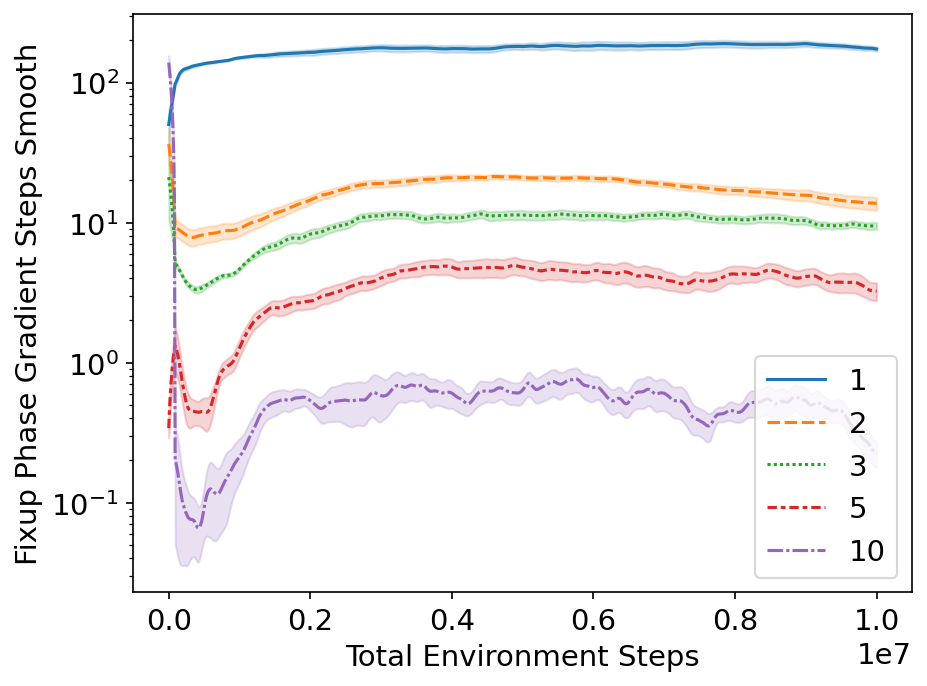

In [95]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Fixup Phase Gradient Steps Smooth",
    hue='$C_{\beta}$',
    errorbar=('se', 1.0),
    style='$C_{\beta}$',
    palette=sns.color_palette("tab10",5),
)
plt.yscale('log')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"fixup_phase_vs_c_beta_{env}.pdf")

In [54]:
all_data.ewm

Signature:
all_data.ewm(
    com: 'float | None' = None,
    span: 'float | None' = None,
    halflife: 'float | TimedeltaConvertibleTypes | None' = None,
    alpha: 'float | None' = None,
    min_periods: 'int | None' = 0,
    adjust: 'bool_t' = True,
    ignore_na: 'bool_t' = False,
    axis: 'Axis' = 0,
    times: 'np.ndarray | DataFrame | Series | None' = None,
    method: 'str' = 'single',
) -> 'ExponentialMovingWindow'
Docstring:
Provide exponentially weighted (EW) calculations.

Exactly one of ``com``, ``span``, ``halflife``, or ``alpha`` must be
provided if ``times`` is not provided. If ``times`` is provided,
``halflife`` and one of ``com``, ``span`` or ``alpha`` may be provided.

Parameters
----------
com : float, optional
    Specify decay in terms of center of mass

    :math:`\alpha = 1 / (1 + com)`, for :math:`com \geq 0`.

span : float, optional
    Specify decay in terms of span

    :math:`\alpha = 2 / (span + 1)`, for :math:`span \geq 1`.

halflife : float, str, timede

In [83]:
all_data.rolling?

Signature:
all_data.rolling(
    window: 'int | dt.timedelta | str | BaseOffset | BaseIndexer',
    min_periods: 'int | None' = None,
    center: 'bool_t' = False,
    win_type: 'str | None' = None,
    on: 'str | None' = None,
    axis: 'Axis' = 0,
    closed: 'str | None' = None,
    step: 'int | None' = None,
    method: 'str' = 'single',
) -> 'Window | Rolling'
Docstring:
Provide rolling window calculations.

Parameters
----------
window : int, timedelta, str, offset, or BaseIndexer subclass
    Size of the moving window.

    If an integer, the fixed number of observations used for
    each window.

    If a timedelta, str, or offset, the time period of each window. Each
    window will be a variable sized based on the observations included in
    the time-period. This is only valid for datetimelike indexes.
    To learn more about the offsets & frequency strings, please see `this link
    <https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases>`__.

In [ ]:
all_data["Fixup Phase Gradient Steps"].ewm(alpha=0.999)